# PCA and TSNE Analysis of Pooled Dataset
### Allison Glynn
### April 6 2024

PCA and TSNE analyses of pooled dataset

In [2]:
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn import tree
import pydotplus
from IPython.display import Image

from sklearn.impute import SimpleImputer

In [3]:
diagnoses = ['ASD', 'AD', 'PD', 'MS']

color_map = {'AD': '#666666',
             'ASD':'#F0027F',
             'MS': '#FDC086',
             'PD': '#7FC97F'}

# load in data:
df = pd.read_csv('../Data/20440_cleaned_data.csv')

# This is for trimming out a certain amount of a diagnosis if we want more equal sizes
# for diag in diagnoses:
#     indexdiag = df[df['Diagnosis'] == diag].index
#     df = df.drop(indexdiag[50:])

#  This is for dropping certain diagnoses for troubleshooting
# for diag in diagnoses:
#     indexdiag = df[df['Diagnosis'] == diag].index
#     df = df.drop(indexdiag)

# For dropping diagnosis column so we can feed data in:
data = df.drop(['Diagnosis'], axis=1) # data without diagnosis column
data = data.drop(['Unknown'], axis=1)

# make a list of diagnoses:
diagnosis = df["Diagnosis"]

Imputation, if necessary:

In [4]:
# imp_mean = SimpleImputer(missing_values=0, strategy='mean')
# imp_mean.fit(data)
# out = imp_mean.transform(data)
# columns = data.columns
# data = pd.DataFrame(out, columns=columns)

Removing small relative abundances, if necessary:

In [5]:
# columns = data.columns
# for col in columns:
#     accept = 0
#     for i in data[col]:
#         if i > 1:
#             accept += 1
#     if accept < 1:
#         data = data.drop([col], axis=1)


Standardization

In [6]:
from sklearn import preprocessing
data_copy = data
columns = data_copy.columns
scaler = preprocessing.StandardScaler().fit(data_copy)
data = pd.DataFrame(scaler.transform(data_copy), columns=columns)

Show data:

In [7]:
data

,Alistipes,Bacteroides,Bifidobacterium,Butyricicoccus,Clostridium,Dorea,Eggerthella,Faecalibacterium,Gemmiger,Prevotella,...,Trichococcus,Anaerococcus,Caulobacter,Elizabethkingia,Flavobacterium,Methylobacterium,Burkholderia,Anoxybacillus,Epulopiscium,Robinsoniella
0,-0.279743,-0.274721,-0.494535,2.908757,-0.264010,-0.310020,0.715602,-0.282054,-0.062637,6.107520,...,-0.050508,-0.100082,-0.050508,-0.058266,-0.060369,-0.050508,-0.050508,-0.050508,-0.050508,-0.050508
1,-0.271075,-0.240027,-0.364661,2.347088,2.647833,-0.364756,-0.422635,-0.423088,-0.097356,-0.254259,...,-0.050508,-0.100082,-0.050508,-0.058266,-0.060369,-0.050508,-0.050508,-0.050508,-0.050508,-0.050508
2,-0.567960,2.190950,-0.499382,1.865787,1.668238,-0.240674,-0.422635,-0.603423,-0.067932,-0.254259,...,-0.050508,-0.100082,-0.050508,-0.058266,-0.060369,-0.050508,-0.050508,-0.050508,-0.050508,-0.050508
3,-0.427820,0.098596,-0.509312,2.718895,0.581342,0.179933,0.412660,1.490248,-0.238172,1.805702,...,-0.050508,-0.100082,-0.050508,-0.058266,-0.060369,-0.050508,-0.050508,-0.050508,-0.050508,-0.050508
4,-0.492406,1.609645,-0.283909,1.191105,1.091819,0.427007,-0.422635,-0.479528,-0.168063,-0.254259,...,-0.050508,-0.100082,-0.050508,-0.058266,-0.060369,-0.050508,-0.050508,-0.050508,-0.050508,-0.050508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,-0.567960,-0.872361,-0.468789,-0.405468,-0.397515,0.337731,0.131916,0.414920,0.734873,-0.254259,...,-0.050508,-0.100082,-0.050508,-0.058266,-0.060369,-0.050508,-0.050508,-0.050508,-0.050508,-0.050508
389,-0.567960,-0.868283,0.520033,-0.405468,0.613997,-0.417634,0.956084,-0.719067,-0.220110,-0.254259,...,-0.050508,-0.100082,-0.050508,1.577908,2.599607,-0.050508,-0.050508,19.798990,-0.050508,-0.050508
390,-0.567960,-0.856151,-0.548851,-0.405468,-0.529913,-0.503255,0.289941,-0.293625,1.349838,-0.254259,...,-0.050508,-0.100082,-0.050508,0.401673,-0.060369,-0.050508,-0.050508,-0.050508,19.798990,-0.050508
391,-0.567960,-0.850705,-0.319388,-0.405468,0.443873,1.430648,6.665385,-0.621448,-0.238172,-0.254259,...,-0.050508,6.264102,-0.050508,-0.058266,-0.060369,-0.050508,-0.050508,-0.050508,-0.050508,19.798990


## PCA of pooled dataset

**Now we perform PCA:**

In [10]:
# prep PCA output dataframe:
columns_list = []

**Run PCA:**

In [11]:
pca = PCA(n_components=.95)
out = pca.fit_transform(data)
for i in range(len(out[0])):
    columns_list.append("PC" + str(i + 1))
    
out_df = pd.DataFrame(out, columns=columns_list)

**Visualize variance ratio explained by each component:**

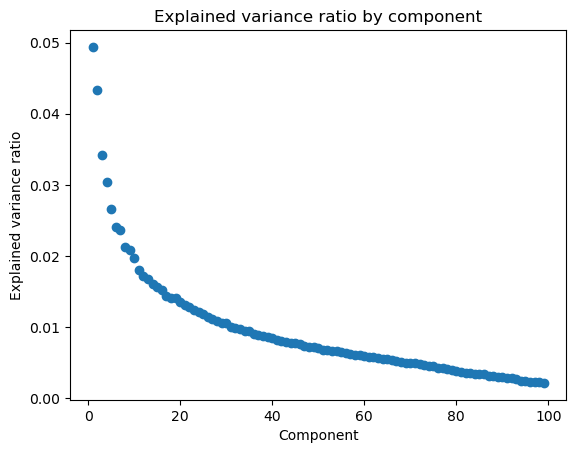

In [13]:
pc = np.linspace(1, len(columns_list), len(columns_list))
var_ratio = pca.explained_variance_ratio_
plt.scatter(pc, var_ratio)
plt.title('Explained variance ratio by component')
plt.xlabel('Component')
plt.ylabel('Explained variance ratio');

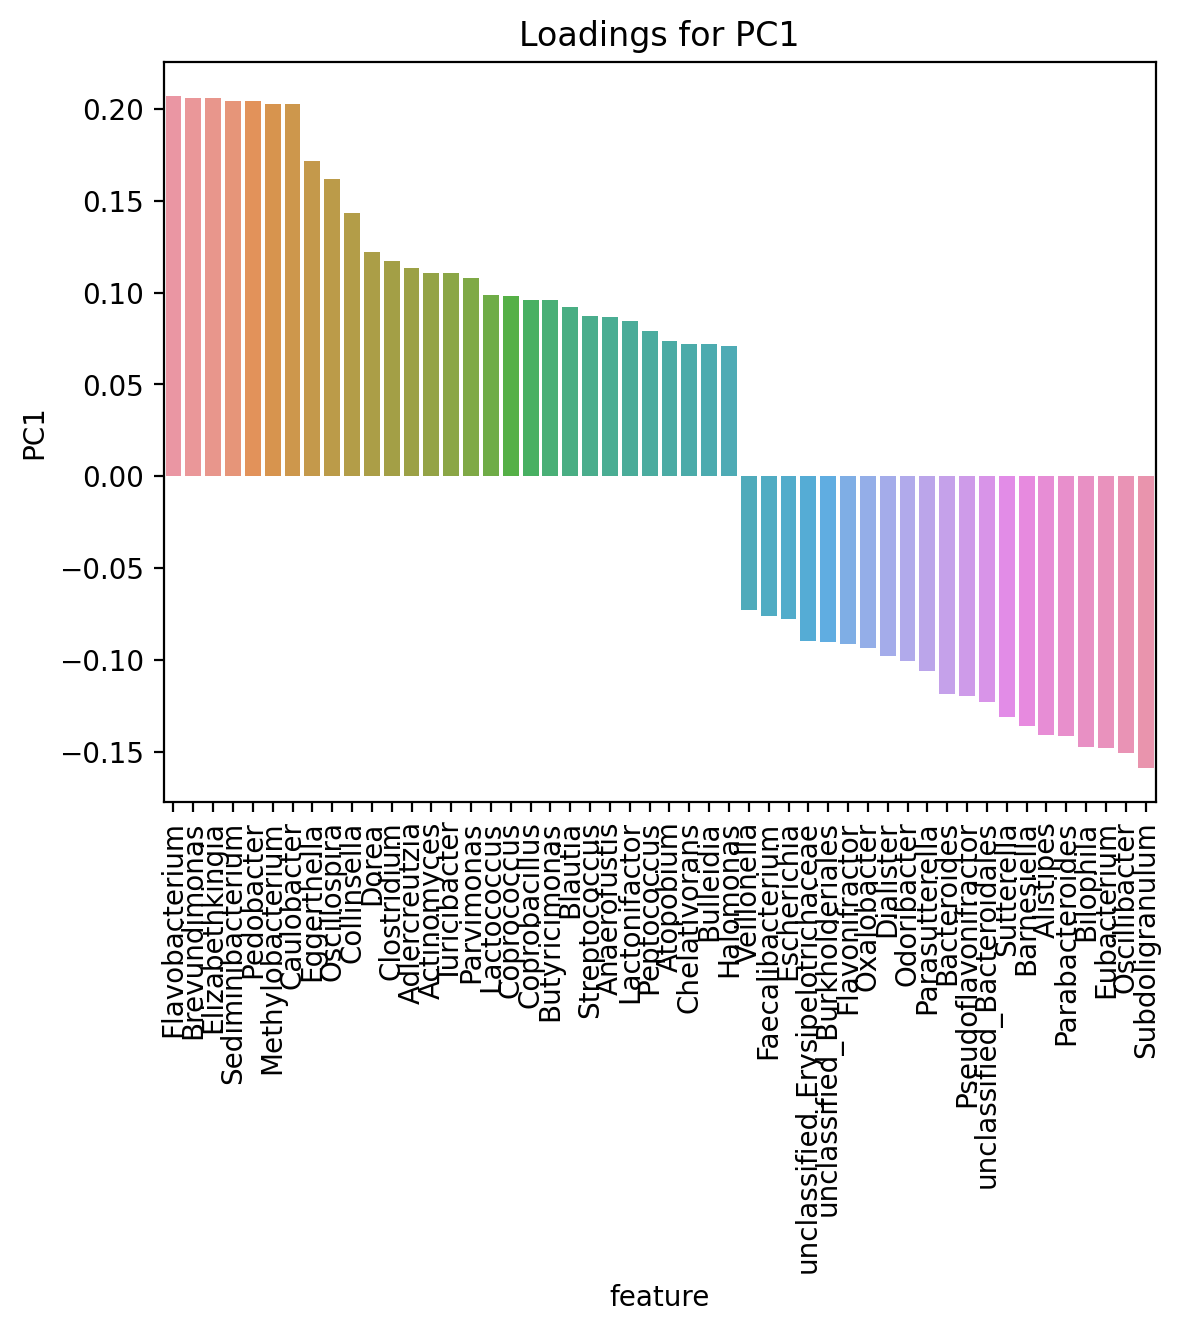

In [18]:
pcs = pca.components_
# create a dataframe with the load of the features in PC1:
load = pd.DataFrame(np.transpose(pcs), columns=['PC'+str(i+1) for i in range(len(columns_list))])
load["feature"] = list(data.columns)

# descending values
load1 = load.sort_values('PC1', ascending=False)
load1_feat = pd.DataFrame(load1[["feature", 'PC1']], columns=['feature', 'PC1']) # for reference

# only keep the big contributors
load1_feat = load1_feat.loc[(load1_feat['PC1'] > .07) | (load1_feat['PC1'] < -.07)]


# plot
plt.figure(dpi=200)
sns.barplot(load1_feat, x='feature', y='PC1')
plt.xticks(rotation=90);
plt.title("Loadings for PC1");
plt.savefig('../Figures/PCA_loadings_pooled.svg')

**Visualize clustering by diagnosis with first two PCs:**

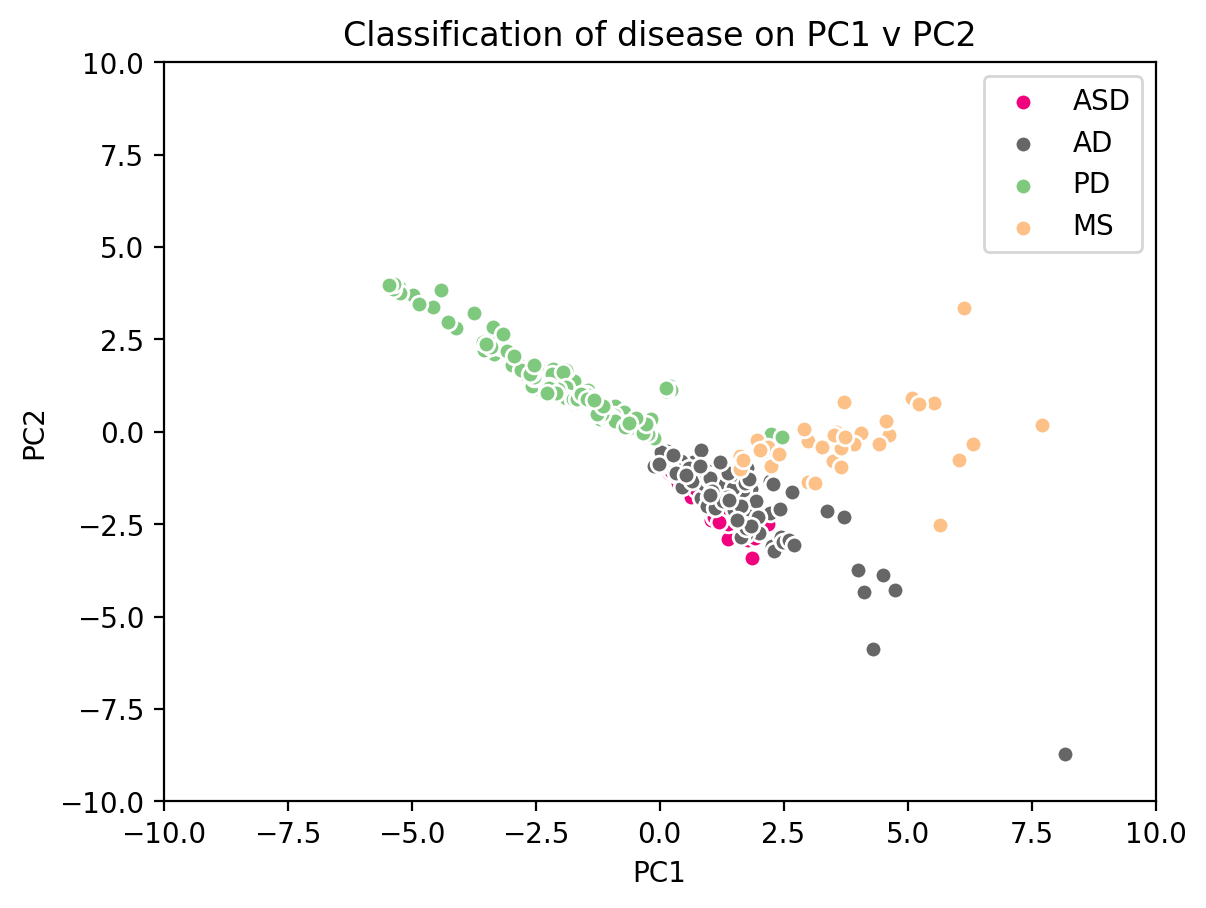

In [23]:
pcs = pca.components_

# set up lists of diagnosis indices:
ASD = []
AD = []
PD = []
Epilepsy = []
MS = []

diagnosis = list(diagnosis)

# indicate which sample indices are which disease:
for i in range(len(diagnosis)):
    if diagnosis[i]=='ASD':
        ASD.append(i)
    if diagnosis[i]=='AD':
        AD.append(i)
    if diagnosis[i]=='PD':
        PD.append(i)
    if diagnosis[i]=='MS':
        MS.append(i)

# plot PC1 v PC2, indicating which indices of these are which disease:
plt.figure(dpi=200)

plt.scatter(out_df['PC1'][ASD], out_df['PC2'][ASD], label='ASD', color = color_map['ASD'], edgecolor='white')
plt.scatter(out_df['PC1'][AD], out_df['PC2'][AD], label='AD', color = color_map['AD'], edgecolor='white')
plt.scatter(out_df['PC1'][PD], out_df['PC2'][PD], label='PD', color = color_map['PD'], edgecolor='white')
plt.scatter(out_df['PC1'][MS], out_df['PC2'][MS], label='MS', color = color_map['MS'],edgecolor='white')

plt.legend();
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.title("Classification of disease on PC1 v PC2");
plt.savefig('../Figures/PCA_plot_pooled.svg')

## K means clustering

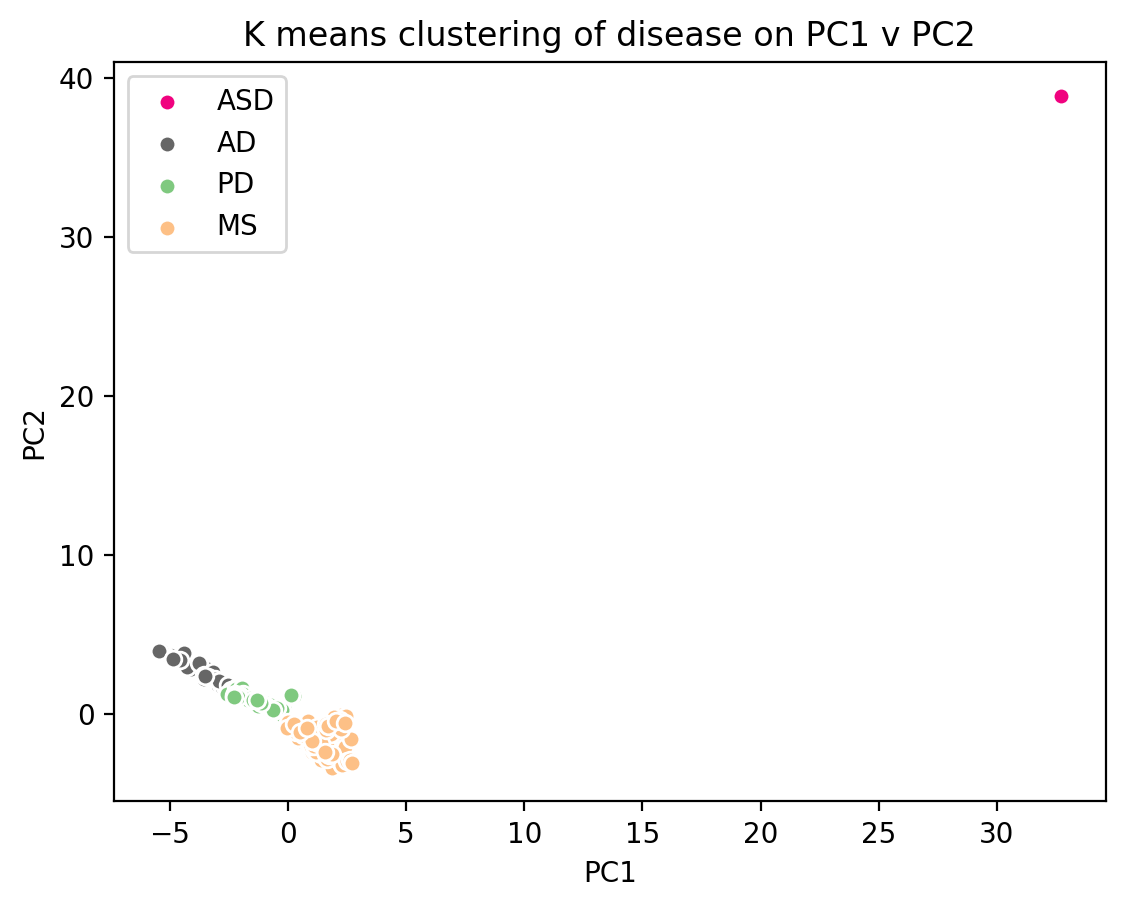

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=False, init='random', n_init="auto").fit(out_df[['PC1', 'PC2']])
# init = random for random selection of centroid
classif = kmeans.labels_ # output is the classifications given by the clustering.

# separate the data points into groups based on the classification

# set up lists of diagnosis indices:
ASD = []
AD = []
PD = []
Epilepsy = []
MS = []

# indicate which sample indices are which disease:
for i in range(len(diagnosis)):
    if classif[i]==0:
        ASD.append(i)
    if classif[i]==1:
        AD.append(i)
    if classif[i]==2:
        PD.append(i)
    if classif[i]==3:
        Epilepsy.append(i)
    if classif[i]==4:
        MS.append(i)

# plot PC1 v PC2, indicating which indices of these are which disease:
plt.figure(dpi=200)
plt.scatter(out_df['PC1'][ASD], out_df['PC2'][ASD], label='ASD', color = color_map['ASD'], edgecolor='white')
plt.scatter(out_df['PC1'][AD], out_df['PC2'][AD], label='AD', color = color_map['AD'], edgecolor='white')
plt.scatter(out_df['PC1'][PD], out_df['PC2'][PD], label='PD', color = color_map['PD'],edgecolor='white')
plt.scatter(out_df['PC1'][MS], out_df['PC2'][MS], label='MS', color = color_map['MS'],edgecolor='white')

plt.legend();
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K means clustering of disease on PC1 v PC2");

## TSNE Analysis

**Run TSNE**

This will be done on the already reduced dimension dataset produced by PCA:

In [36]:
# run TSNE
# X_embedded = TSNE(n_components=2, learning_rate='auto', 
#                   init='random', perplexity=25, n_iter=3000).fit_transform(out_df)
X_embedded = TSNE(n_components=2, n_iter=3000, perplexity=12, early_exaggeration=1, learning_rate='auto',
                 metric='euclidean', method='exact').fit_transform(out_df)

In [37]:
# Create dataframe with output (component 1 is 0, component 2 is 1):
TSNE_df = pd.DataFrame(X_embedded)

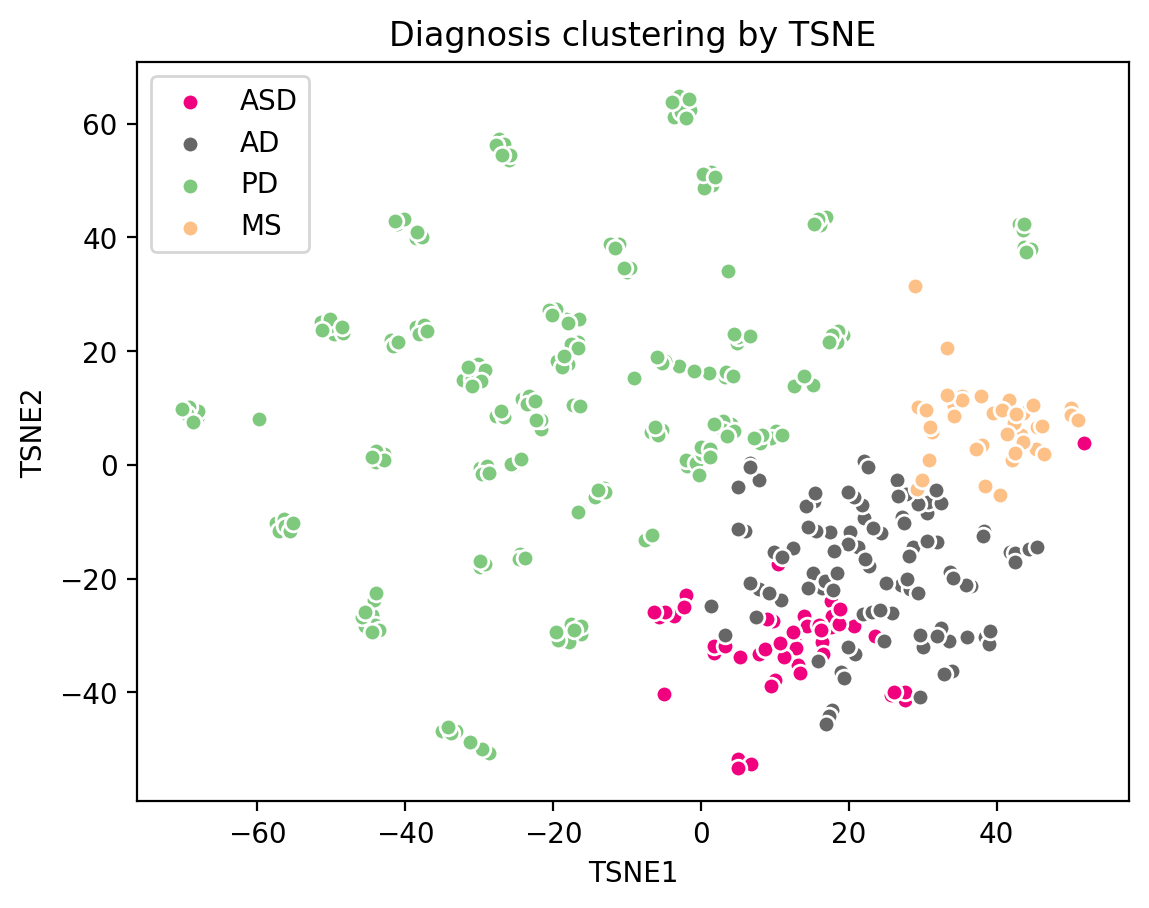

In [38]:
# set up lists of diagnoses indices:
ASD = []
AD = []
PD = []
Epilepsy = []
MS = []

# indicate which sample indices are which diagnoses:
for i in range(len(diagnosis)):
    if diagnosis[i]=='ASD':
        ASD.append(i)
    if diagnosis[i]=='AD':
        AD.append(i)
    if diagnosis[i]=='PD':
        PD.append(i)
    if diagnosis[i]=='MS':
        MS.append(i)

plt.figure(dpi=200)

#plot component 1 v component 2, indicating which indices are which diagnosis:
plt.scatter(TSNE_df[0][ASD], TSNE_df[1][ASD], label='ASD', color = color_map['ASD'], edgecolor='white')
plt.scatter(TSNE_df[0][AD], TSNE_df[1][AD], label='AD', color = color_map['AD'], edgecolor='white')
plt.scatter(TSNE_df[0][PD], TSNE_df[1][PD], label='PD', color = color_map['PD'], edgecolor='white')
plt.scatter(TSNE_df[0][MS], TSNE_df[1][MS], label='MS', color = color_map['MS'], edgecolor='white')


plt.legend();
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.title("Diagnosis clustering by TSNE");
plt.savefig('../Figures/TSNE_plot_pooled.svg')

## RF Classifier

In [54]:
# set up classifier
rf = RandomForestClassifier(n_estimators=100) # 100 trees in the forest.
# 100 trees means 100 sub-samples of data

# make training and testing sets:
feat_train, feat_test, diag_train, diag_test = sk.model_selection.train_test_split(data, diagnosis, test_size=0.3)
# chose a test size of 30%

# train:
out = rf.fit(feat_train, diag_train)

# test:
diag_predict = rf.predict(feat_test)

**Accuracy of classifier**

In [55]:
acc = sk.metrics.accuracy_score(diag_test, diag_predict)
print("accuracy of the classifier: {}".format(acc))

accuracy of the classifier: 0.9915254237288136


**Table of importances**

In [56]:
feat = data.columns

In [57]:
# find importance of each feature:
feat_importance = rf.feature_importances_

# make and print table of ranked features by importance:
imp_table = pd.DataFrame(feat, columns=['features'])
imp_table['importance'] = feat_importance
imp_table_sort = imp_table.sort_values('importance', ascending=False)
feat_sort = list(imp_table_sort['features']) # use this for plotting and storing the features
imp_table_sort.head()

,features,importance
94,Eubacterium,0.084456
97,Oscillibacter,0.079902
93,Blautia,0.059332
4,Clostridium,0.048217
44,Parabacteroides,0.045260


**XY scatter of important features**

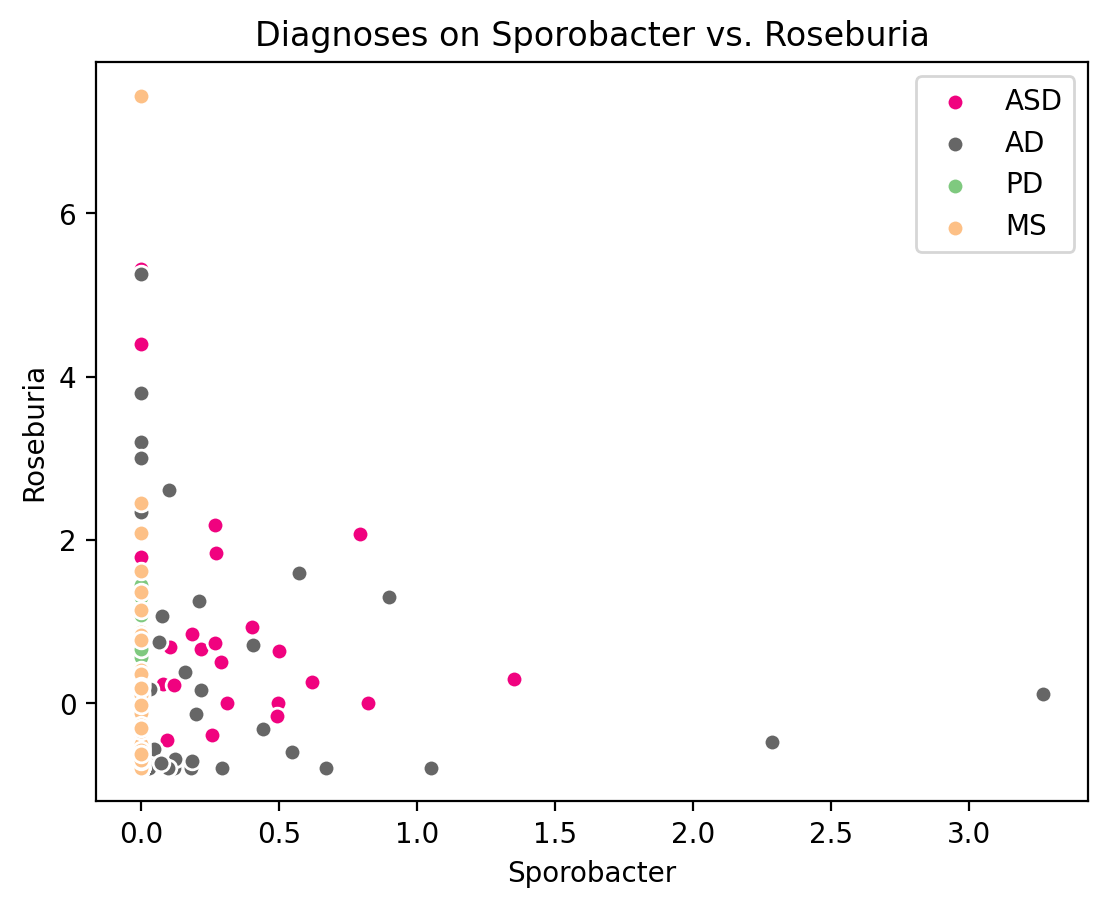

In [49]:
# use the top two most important features from the table of ranked importances
plt.figure(dpi=200)
plt.scatter(df[feat_sort[0]][ASD], data[feat_sort[1]][ASD], label='ASD', color = color_map['ASD'], edgecolor='white')
plt.scatter(df[feat_sort[0]][AD], data[feat_sort[1]][AD], label='AD', color = color_map['AD'], edgecolor='white')
plt.scatter(df[feat_sort[0]][PD], data[feat_sort[1]][PD], label='PD', color = color_map['PD'], edgecolor='white')
plt.scatter(df[feat_sort[0]][MS], data[feat_sort[1]][MS], label='MS', color = color_map['MS'], edgecolor='white')

plt.legend()

plt.xlabel(feat_sort[0]);
plt.ylabel(feat_sort[1]);
plt.title("Diagnoses on " + str(feat_sort[0]) + ' vs. ' + str(feat_sort[1]));
plt.savefig('../Figures/RF_feature_plot_pooled.svg')

**Look at Gini importance and get decision tree**

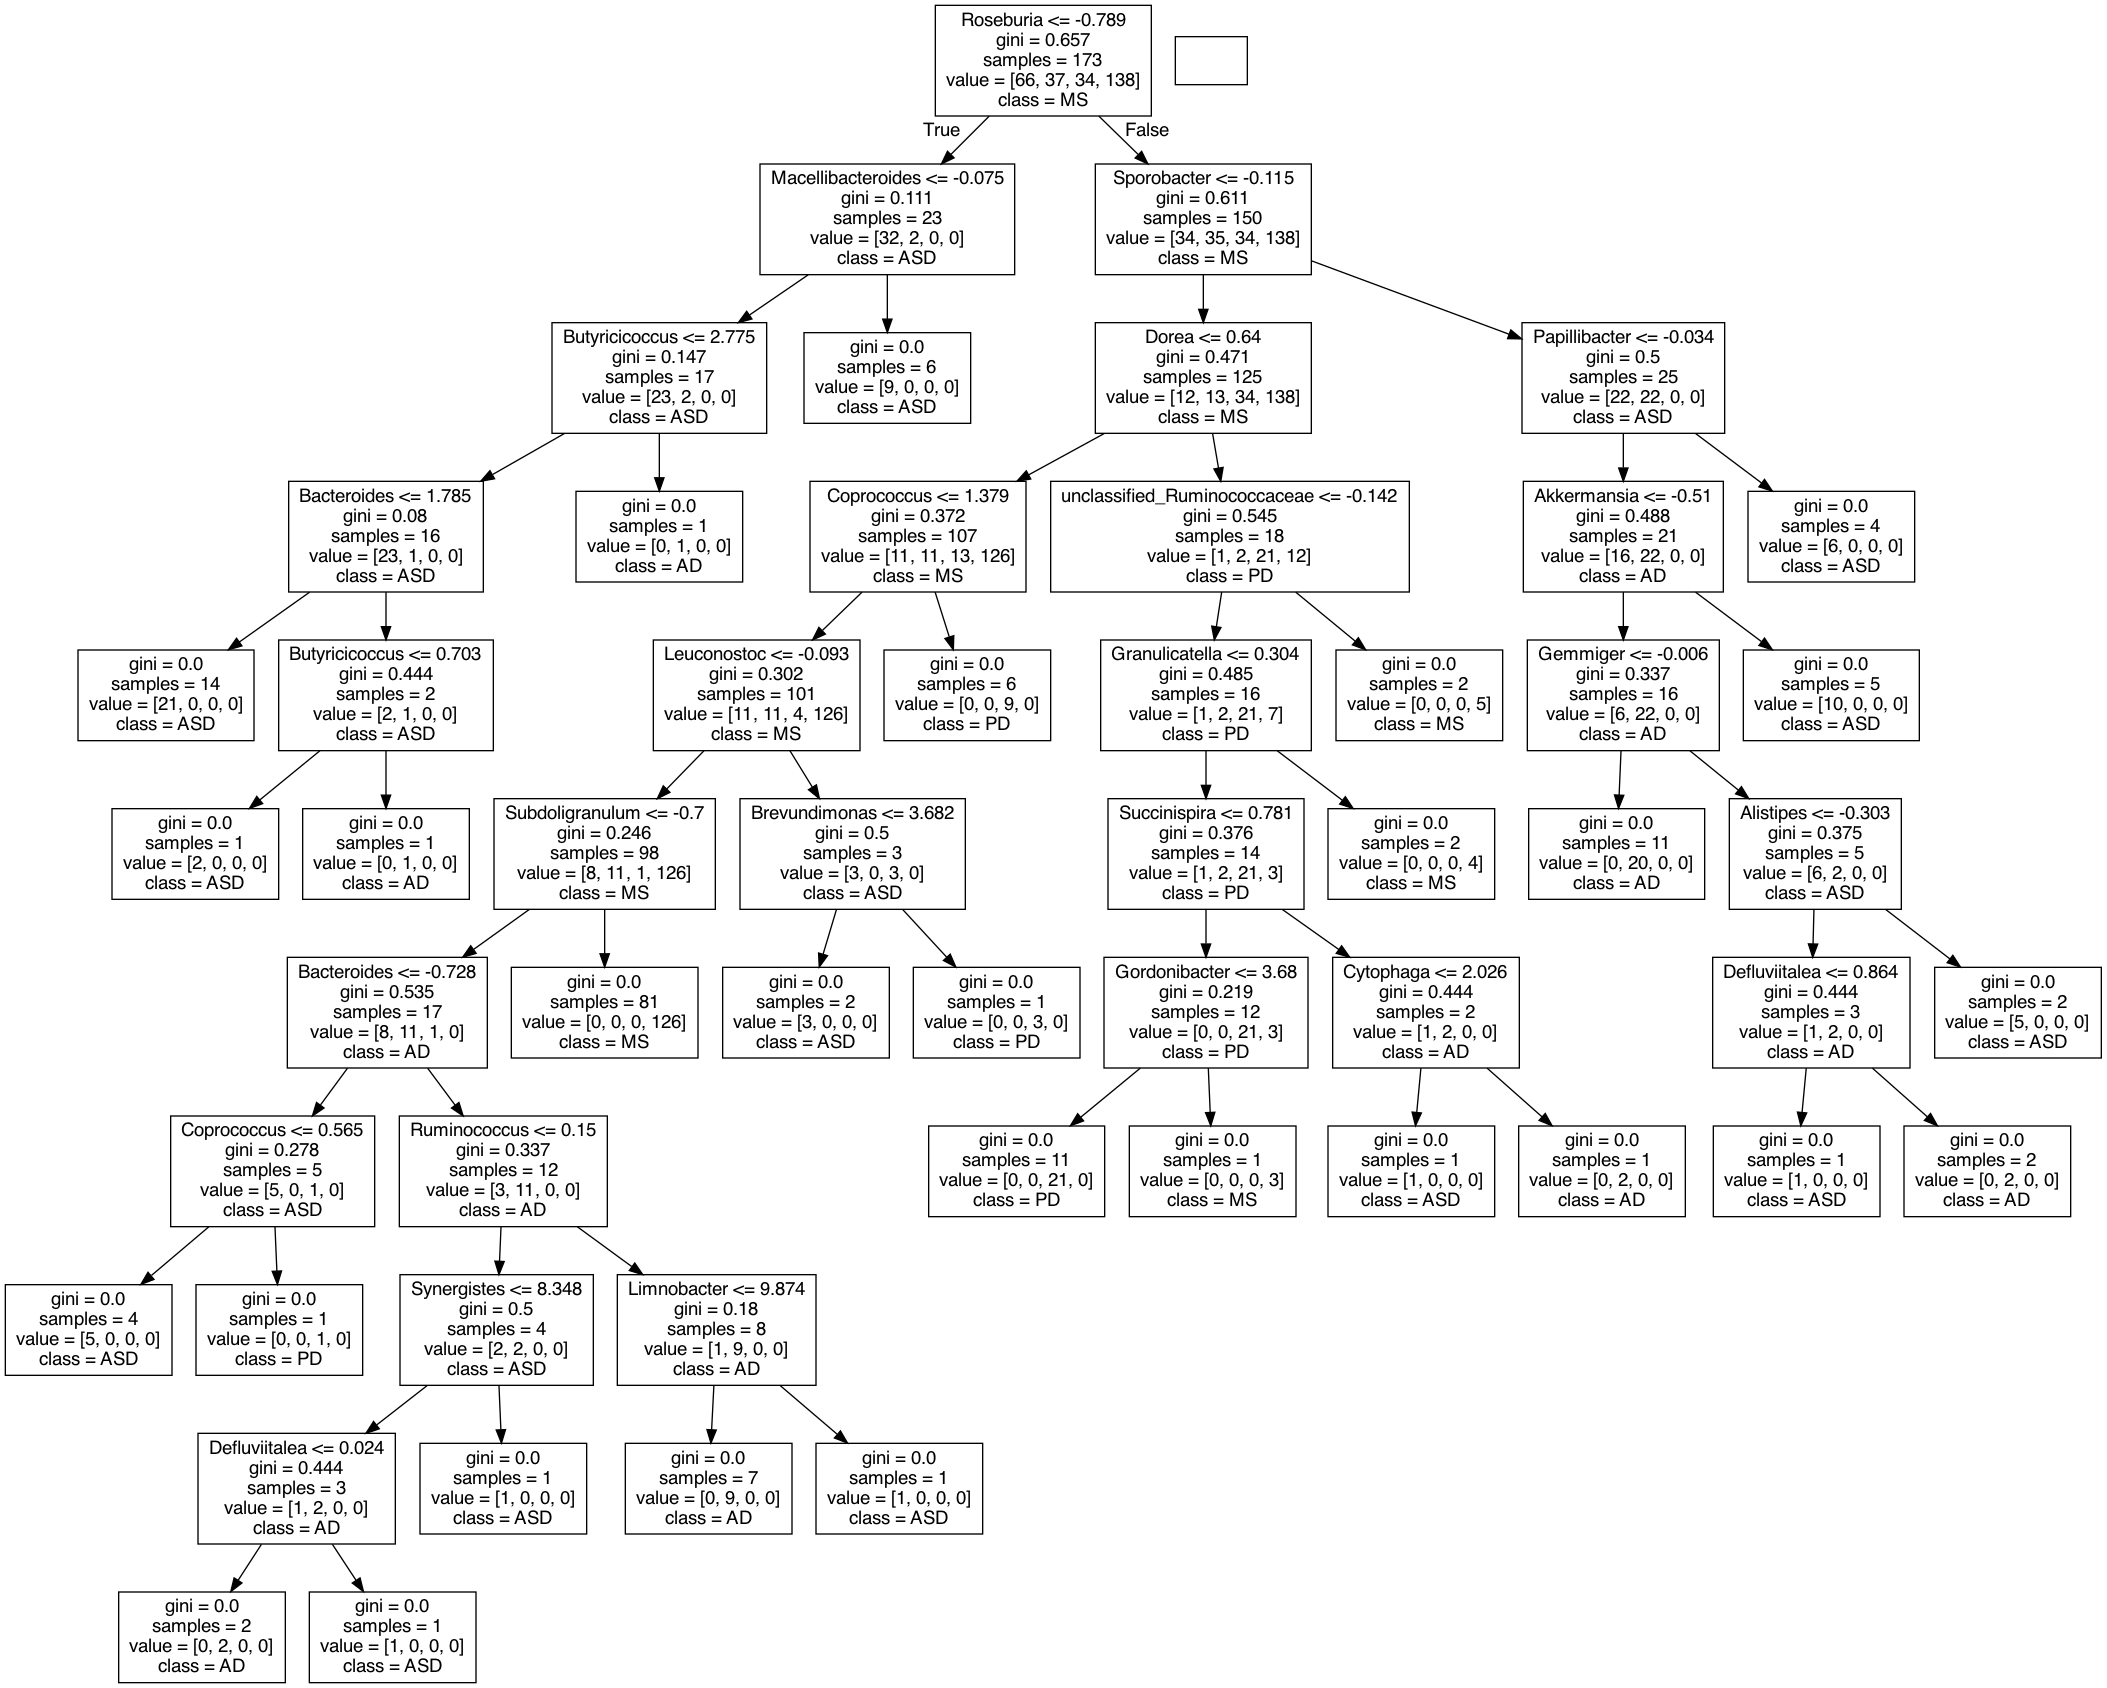

In [51]:
# followed this tutorial for getting image: https://naysan.ca/2019/11/26/visualize-a-decision-tree-with-sklearn/
# i just plotted one of the trees:
out_file = sk.tree.export_graphviz(out[0],label='all', feature_names=feat, class_names= ['ASD', 'AD', 'PD', 'MS'])

graph = pydotplus.graph_from_dot_data(out_file)
Image(graph.create_png())